In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random
import torchvision

In [ ]:
!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..
!pip install -U pytorch_warmup
import pytorch_warmup as warmup

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [4]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


## To Do: 

### Get the google collab pipeline onto a python script. Look at paperswithcode to see how typical projects split their code (datasets.py / train.py etc.).

### Rename and label the other data.

### Use Augmentations and more data that will help me deal with the face problem rigth now. Try to focus on the finetuning the model using andrej karpathy's blog http://karpathy.github.io/2019/04/25/recipe/.Trying new models


### Train, Once I get a model with very good results. torch.save it state_dicts on my local disk. Also record results of models on results spreadsheet.

Less Urgent:
### Look at new project ideas. Read about new ideas into agriculture and look for problems that can be solved with computer vision. Also, develop note-taking idea a little bit.
 

In [5]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/LatestFruitDataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [12]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)
freshApples_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplebtch2label/FreshApplesBatch2LabelsFresh.csv", header = None)
freshApples_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplesBatch1Labels/FreshAppleBatch1Labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3, freshApples_csv_batch_2, freshApples_csv_batch_1]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))

def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

Checked total rows from all the dataframes combined: 1100
DataFrame shape: (1100, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 344


In [13]:
#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

DataFrame shape: (1100, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot']
Number of Unique Images 344


In [14]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [15]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Placeholder", "Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

343
343


## Class function + util functions

In [16]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [141]:
# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.GaussianBlur(), 
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      A.IAAPiecewiseAffine(),
                      A.ChannelDropout(), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    raise ValueError("mode is wrong value can either be train or test")

In [144]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 2
test_batch_size = 5

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)


In [138]:
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        if put_text:
          cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                      lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

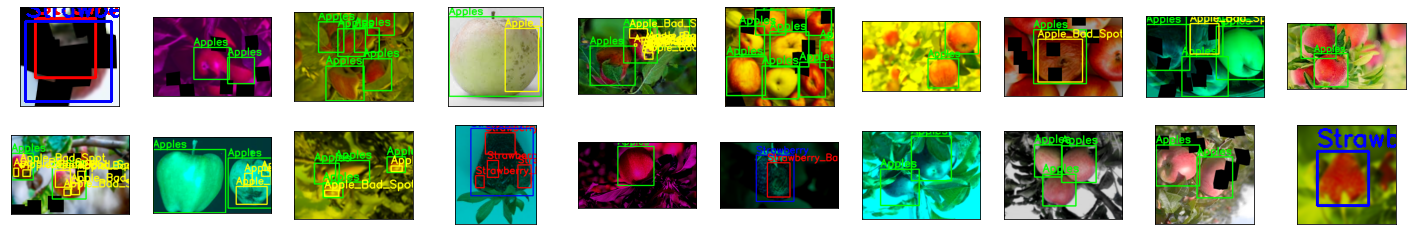

In [143]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [145]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

def Graph_Maker(Train_l,Test_L, print_every):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss Value over Time")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(np.arange(1, len(Train_l)+1))
  plt.show()

https://pypi.org/project/pytorch-warmup/ link for doing warmup

In [146]:
def train(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()

    train_list = test_list = []
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()

            losses.backward()
            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())
                  test_loss += test_losses.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Test Images: {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))

              train_list.append(train_loss)
              test_list.append(test_loss)

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    Graph_Maker(train_list, test_list, print_every)

    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




### Let us try another bigger model - Not Working

In [108]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

bigger_model = FasterRCNN(backbone,
                   num_classes= 4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
big_model = train(bigger_model, 5, train_loader, test_loader, 0.001, weight_decay = 1e-4, print_every = 25)

### The Mobile Net Model

In [147]:
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
backbone.roi_heads.box_predictor.cls_score.out_features = 4
backbone.roi_heads.box_predictor.bbox_pred.out_features = 16
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.001
    k: 6
    lr: 0.001
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/7 | Batch Number: 40 | LR: 0.00 | Train_loss: 141.71 | Test_loss: 17.92 | Test mAP: 11.17% | Test mAR: 24.34% | Missed Test Images: 42
Epoch 1/7 | Batch Number: 80 | LR: 0.00 | Train_loss: 58.33 | Test_loss: 9.39 | Test mAP: 47.77% | Test mAR: 68.36% | Missed Test Images: 14
Epoch 1/7 | Batch Number: 120 | LR: 0.00 | Train_loss: 34.70 | Test_loss: 9.89 | Test mAP: 7.50% | Test mAR: 99.45% | Missed Test Images: 0

 Epoch 1 Final Train mAP: 16.73% | Epoch 1 Final Train mAR: 58.77% | Epoch 1 Final Missed Train Images: 96 out of 274 images 

Epoch 2/7 | Batch Number: 40 | LR: 0.00 | Train_loss: 28.47 | Test_loss: 8.21 | Test mAP: 15.36% | Test mAR: 99.57% | Missed Test Images: 0
Epoch 2/7 | Batch Number: 80 | LR: 0.00 | Train_loss: 32.19 | Test_loss: 7.48 | Test mAP: 34.73% | Test mAR: 98.16% | Missed Test Images: 0
Epoch 2/7 | Batch Number: 120 | LR: 0.00 | Train_loss: 28.79 | Test_loss: 7.49 | Test mAP: 56.53% | Test mAR: 93.15% | Missed Test Images: 0

 Epoch 2 Final Train mAP: 

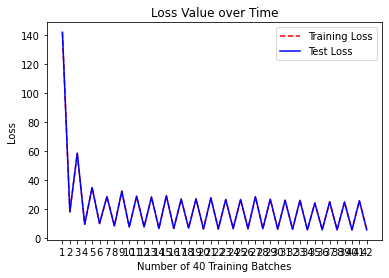

In [148]:
another_one = train(backbone, 7, train_loader, test_loader, 0.001, weight_decay = 1e-4, print_every = 40)

In [ ]:
torch.save(another_one.state_dict(), "five_epochs.pth")

In [149]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def calculate_iou_on_label(results, len_of_results, iou_thresh, device):
  for current_index, _ in enumerate(results["boxes"]):
    if current_index >= len_of_results:
      break

    current_index_iou = jaccard_iou(results["boxes"][current_index].view(1, -1).to(device),
                                    results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in results:
      results[key] = results[key][~mask]

    len_of_results -= sum(mask)
  
  return results

In [150]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, webcam = False, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  if not webcam:
    torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
    trained_model.to(device)
    trained_model.eval()
    print("Image Size: {}".format(torch_image.size()))

    start_time = time.time()
    results = trained_model(torch_image)
    end_time = time.time() - start_time

    print("Time of Inference {:0.2f}".format(end_time))
  else:

    torch_image = F.to_tensor(image_file_path).unsqueeze(1).to(device)

    results = trained_model(torch_image)

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  
  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  #This is where I place the order of the list
  fruit_spot_iou_thresh, bad_spot_iou_thresh = iou_thresh

  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label == 3 or label == 4]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()

  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  if len_of_bad_spots > 1:
    bad_spot_results = calculate_iou_on_label(bad_spot_results, len_of_bad_spots, bad_spot_iou_thresh, device)
  if len_of_fruit > 1:
    fruit_results = calculate_iou_on_label(fruit_results, len_of_fruit, fruit_spot_iou_thresh, device)
  
  for key in results[0]: 
    if (key == "boxes"):
      results[0]["boxes"] = torch.cat((fruit_results["boxes"], bad_spot_results["boxes"]), axis = 0)
    else:
      results[0][key] = torch.cat((fruit_results[key], bad_spot_results[key]), dim = 0)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    written_image = cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True, put_text= True), cv2.COLOR_BGR2RGB)
    plt.imshow(written_image)
  
  return results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 750, 1000])
Time of Inference 0.02


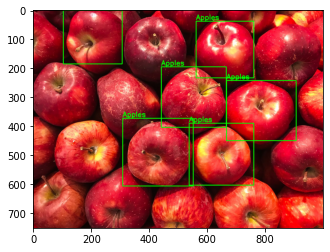

In [151]:
results = infer_image("/content/Fruit Defects Dataset /Predict_Examples/appssss.jpeg", another_one, 0.6, [0.3, 0.1])

Image Size: torch.Size([1, 3, 409, 615])
Time of Inference 0.02


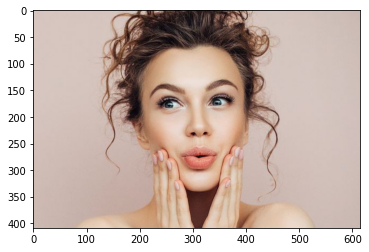

In [154]:
results = infer_image("/content/face_test.jpg", another_one, 0.5, [0.3, 0.1])

In [66]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      /* try changing the capture canvas and see what happens*/
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [67]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [78]:
data_transforms = get_transforms(mode = "test")

In [155]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 

color=None
label=None
line_thickness=None
another_one.to(device).eval();
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    prediciton = infer_image(image, another_one, 0.2, [0.3, 0.1], webcam= True, show_image = False)

    drawing_array = np.zeros([512,512,4], dtype=np.uint8)

    for x in prediciton[0]['boxes']:

      tl = line_thickness or round(0.002 * (drawing_array.shape[0] + drawing_array.shape[1]) / 2) + 1  # line/font thickness
      color = color or [random.randint(0, 255) for _ in range(3)]
      c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
      cv2.rectangle(drawing_array, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
      if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(drawing_array, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(drawing_array, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

    img_data = drawing_bytes

<IPython.core.display.Javascript object>